<a href="https://colab.research.google.com/github/avarlotta/time-series-forecasting/blob/main/forecasting_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install google-cloud-bigquery

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
from google.cloud import bigquery
client = bigquery.Client(project='prism-insights')

In [5]:
query = '''WITH sales_per_month AS (SELECT EXTRACT(YEAR FROM event_date) AS year,
                  EXTRACT(MONTH FROM event_date) AS month,
                  COUNT(event_name) AS num_sales
           FROM `prism-insights.prism_insights_dev.stg_funnel_events`
           WHERE event_name = 'purchase'
           GROUP BY year, month
           ORDER BY year, month)
           SELECT DATE(CAST(year AS INT), CAST(month AS INT), 1) AS DoM,
                  num_sales
           FROM sales_per_month
        '''
df = client.query(query).to_dataframe()

In [6]:
df.dtypes

DoM          dbdate
num_sales     Int64
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   DoM        28 non-null     dbdate
 1   num_sales  28 non-null     Int64 
dtypes: Int64(1), dbdate(1)
memory usage: 604.0 bytes


In [8]:
df.head()

,DoM,num_sales
0,2020-01-01,13240
1,2020-02-01,12079
2,2020-03-01,13359
3,2020-04-01,18047
4,2020-05-01,29450


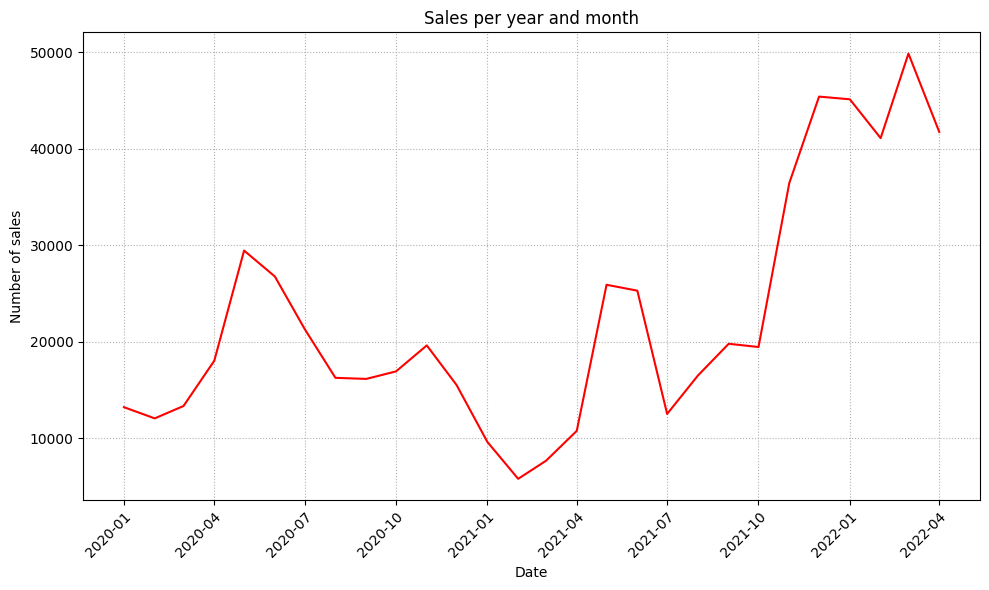

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df.DoM, df.num_sales, color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Number of sales')
ax.set_title('Sales per year and month')
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor", rotation=45)
plt.grid(linestyle=':')
plt.tight_layout();

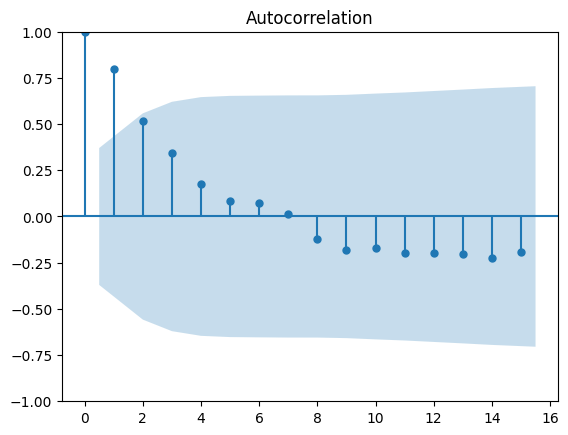

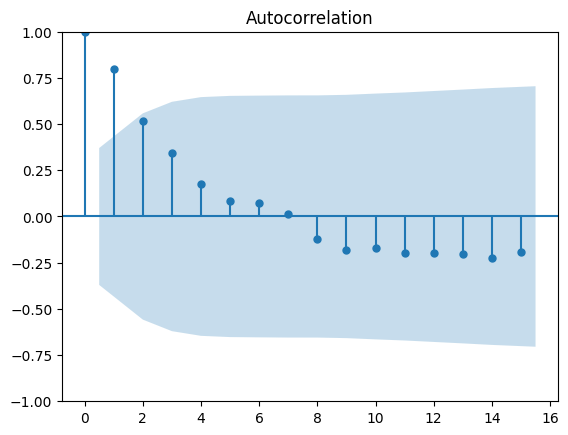

In [21]:
plot_acf(df.num_sales)

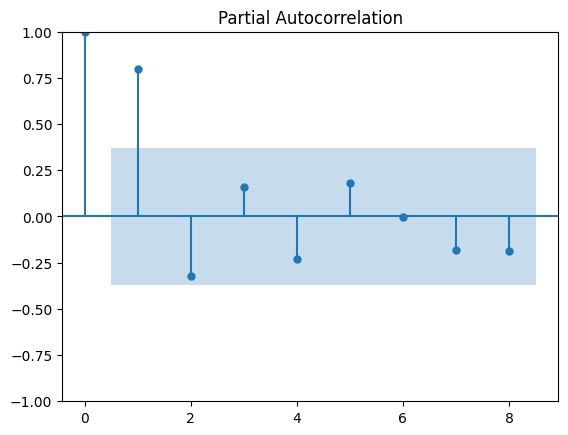

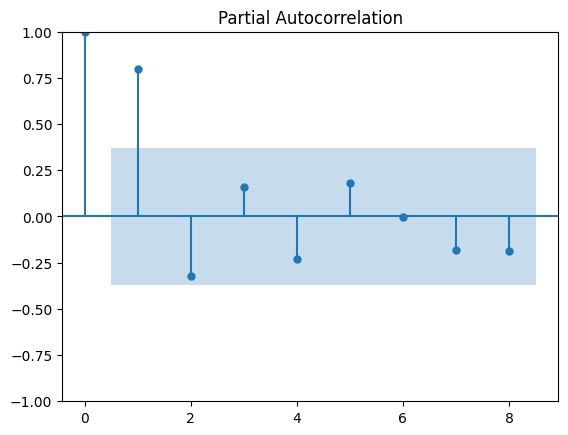

In [20]:
plot_pacf(df.num_sales, lags=8)

In [26]:
# arima_model = ARIMA(df, order=(2, 0 ,2))